# Cell shape analysis

## Setup

In [2]:
import os
import sys
import warnings

sys.path.append(os.path.dirname(os.getcwd()))
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt

import geomstats.backend as gs

INFO: Using numpy backend


## Generation of simple discrete curves

In [4]:
# Return a discrete closed curve (array of 2D points) representing a square
# in counter-clockwise order
def unit_square(nb_points_side):
    nb_points = 2*(nb_points_side) + 2*(nb_points_side - 2) + 1
    square = gs.zeros((nb_points, 2))
    
    pos_axis = gs.linspace(-1, 1, nb_points_side)
    neg_axis = gs.flip(pos_axis)
    ones = gs.ones(nb_points_side)
    minus_ones = -ones
    
    square[:nb_points_side] = gs.vstack((pos_axis, minus_ones)).T
    square[nb_points_side - 1 : 2*nb_points_side - 1] = gs.vstack((ones, pos_axis)).T
    square[2*nb_points_side - 2 : 3*nb_points_side - 2] = gs.vstack((neg_axis, ones)).T
    square[3*nb_points_side - 3 : 4*nb_points_side - 3] = gs.vstack((minus_ones, neg_axis)).T
    
    return square

# Return a discrete closed curve (array of 2D points) representing an ellipse of equation x²/a² + y²/b² = 1
# in counter-clockwise order
def unit_ellipse(nb_points, a, b):
    t = gs.linspace(0, 2*gs.pi, nb_points)
    x = a*gs.cos(t)
    y = b*gs.sin(t)
    ellipse = gs.vstack((x, y)).T
    
    return ellipse


# Return a discrete closed curve (array of 2D points) representing a circle
# in counter-clockwise order
def unit_circle(nb_points_half):
    return unit_ellipse(nb_points_half, 1, 1)

I generated arrays of points such that the first and last points are equal, is that necessary ?

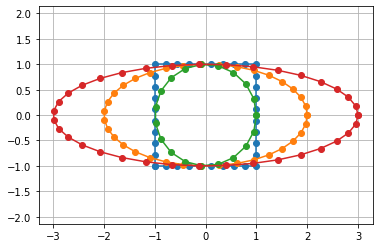

In [5]:
# Plot a discrete curve (array of 2D points)
def plot_curve(curve):
    plt.plot(curve[:, 0], curve[:, 1], 'o-')
    
plot_curve(unit_square(10))
plot_curve(unit_ellipse(36, 2, 1))
plot_curve(unit_circle(20))
plot_curve(unit_ellipse(36, 3, 1))
plt.axis('equal')
plt.grid()

## Geodesics between simple curves

In [6]:
from geomstats.geometry.discrete_curves import R2, DiscreteCurves, SRVMetric

curves = DiscreteCurves(R2)
metric = curves.square_root_velocity_metric

square = unit_square(10)
circle = unit_circle(37)

geodesic = metric.geodesic(initial_curve=square, end_curve=circle)

points = geodesic(gs.linspace(0., 1., 10))

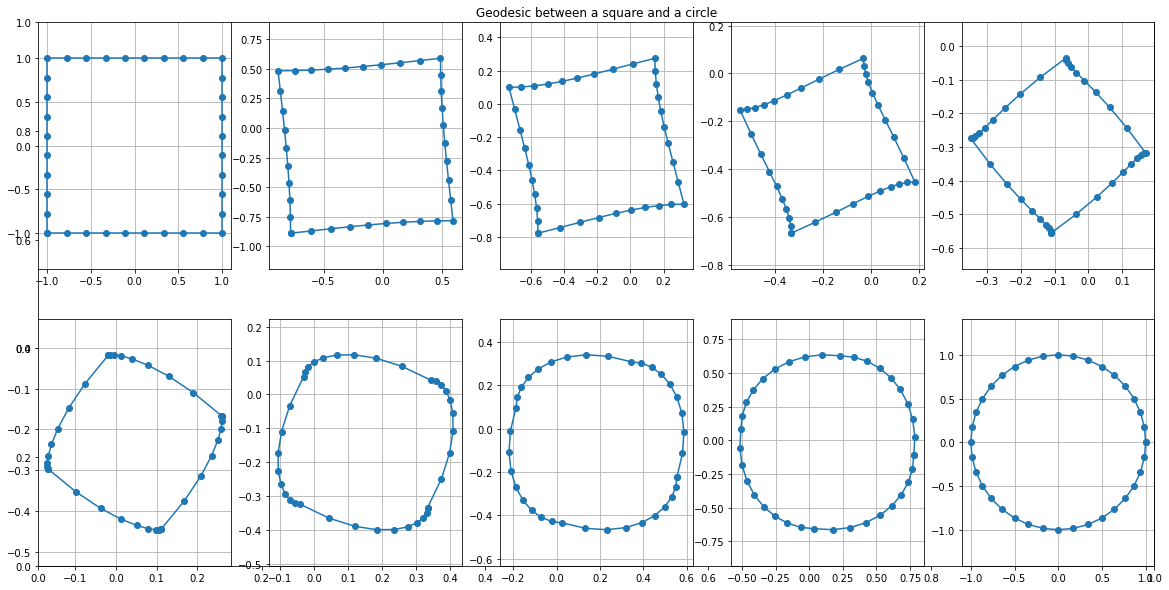

In [7]:
fig = plt.figure(figsize = (20, 10))
plt.title("Geodesic between a square and a circle")

for i in range(len(points)):
    fig.add_subplot(2, len(points)/2, i + 1)
    plot_curve(points[i])
    plt.axis('equal')
    plt.grid()

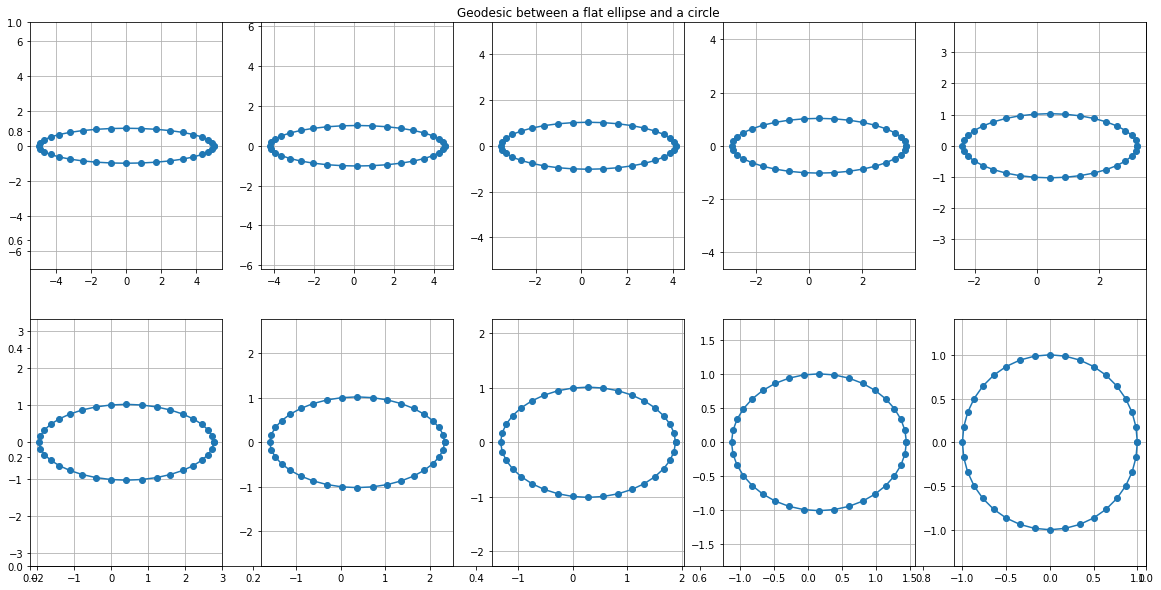

In [8]:
flat_ellipse = unit_ellipse(37, 5, 1)
circle = unit_circle(37)

geodesic = metric.geodesic(initial_curve=flat_ellipse, end_curve=circle)

points = geodesic(gs.linspace(0., 1., 10))

fig = plt.figure(figsize = (20, 10))
plt.title("Geodesic between a flat ellipse and a circle")

for i in range(len(points)):
    fig.add_subplot(2, len(points)/2, i + 1)
    plot_curve(points[i])
    plt.axis('equal')
    plt.grid()

## Geodesics between perturbations of simple curves

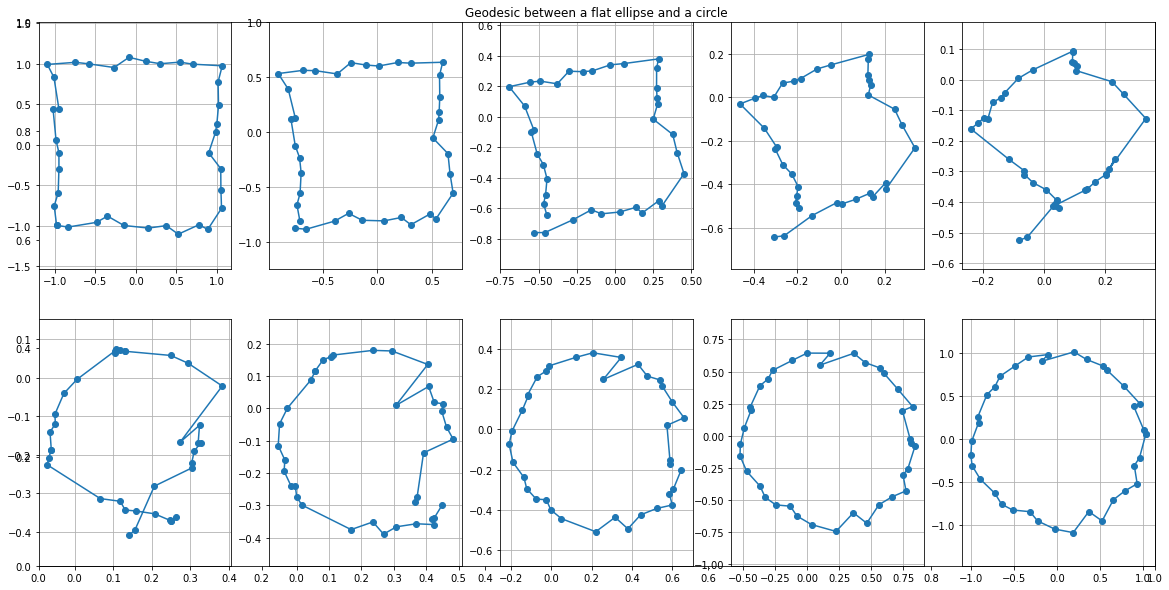

In [9]:
sigma = 0.05
gs.random.seed(1234)

gaussian_noise_1 = gs.vstack((gs.random.normal(0, sigma, 36), gs.random.normal(0, sigma, 36))).T
gaussian_noise_1 = gs.concatenate((gaussian_noise_1, [gaussian_noise_1[0]]))
gaussian_noise_2 = gs.vstack((gs.random.normal(0, sigma, 36), gs.random.normal(0, sigma, 36))).T
gaussian_noise_2 = gs.concatenate((gaussian_noise_2, [gaussian_noise_2[0]]))

perturbed_square = square + gaussian_noise_1
#print(perturbed_square)
perturbed_circle = circle + gaussian_noise_2
#print(perturbed_circle)

geodesic = metric.geodesic(initial_curve=perturbed_square, end_curve=perturbed_circle)

points = geodesic(gs.linspace(0., 1., 10))

fig = plt.figure(figsize = (20, 10))
plt.title("Geodesic between a flat ellipse and a circle")

for i in range(len(points)):
    fig.add_subplot(2, len(points)/2, i + 1)
    plot_curve(points[i])
    plt.axis('equal')
    plt.grid()

Why do the curves become open along the geodesic ?